光束大小已修改为: 6000.0μm x 6000.0μm
探测器已更新为 Mercu 1717V 参数:
  像素尺寸: 139.0μm x 139.0μm
  像素矩阵: 3072 x 3072
  物理尺寸: 427.0mm x 427.0mm
  探测器距离: 1324.9mm
样品直径已修改为: 4000.0μm (即 4.0mm)
样品材料: 镍 (Nickel), 结构信息从 Ni.cif 加载
基准取向已设定: 晶体 [1 1 0] 方向 || 光束 [1 0 0] 方向
为样品添加正态分布的取向扩展 (标准差 sigma = 2°)...
已为所有 42576 个单元生成了目标取向的晶粒。
将点扩展函数核大小设置为 (33, 33)
Rendering 7605 scattering volumes unto the detector     |████████████████████████████████████████| 100.0%
原始数据最大值: inf
使用幂律标尺显示，范围: vmin=0.00e+00, vmax=3.03e+11


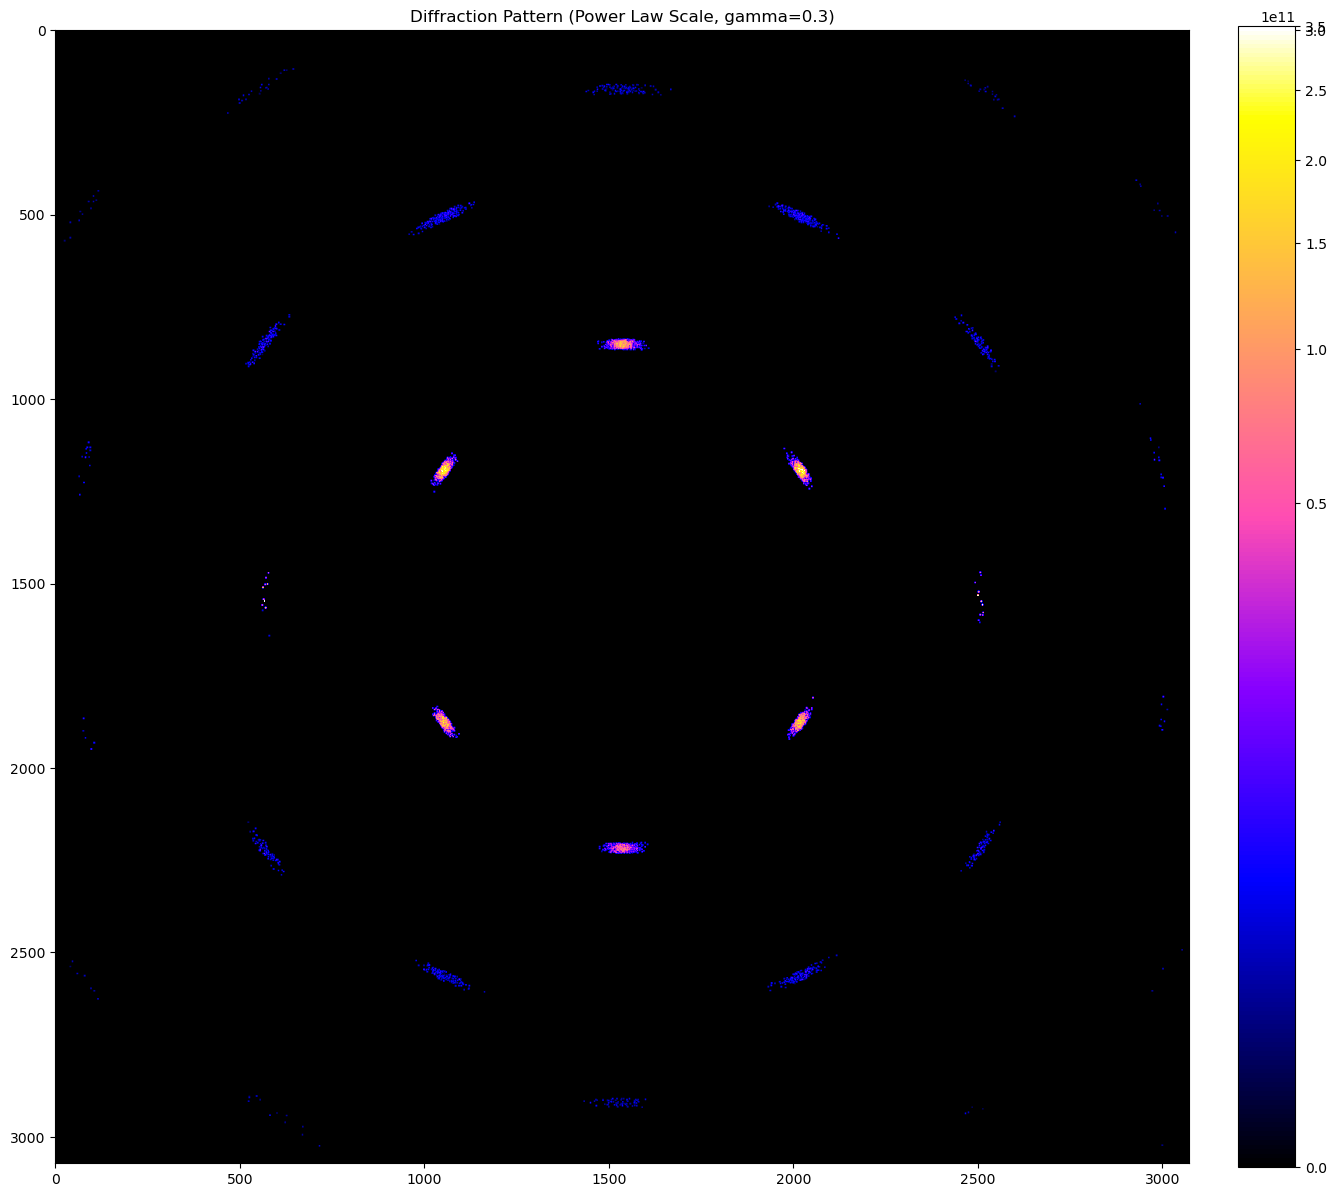

In [21]:
import numpy as np
from xrd_simulator.beam import Beam
from xrd_simulator.detector import Detector
from xrd_simulator.mesh import TetraMesh
from xrd_simulator.phase import Phase
from xrd_simulator.polycrystal import Polycrystal
from xrd_simulator.motion import RigidBodyMotion
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

# --- 光束定义 (修改) ---
beam_edge = 2500.
beam = Beam(
    np.array([
        [-5e6, -beam_edge, -beam_edge], [-5e6, beam_edge, -beam_edge], [-5e6, beam_edge, beam_edge], [-5e6, -beam_edge, beam_edge],
        [5e6, -beam_edge, -beam_edge], [5e6, beam_edge, -beam_edge], [5e6, beam_edge, beam_edge], [5e6, -beam_edge, beam_edge]
    ]),
    xray_propagation_direction=np.array([1., 0., 0.]),
    wavelength=0.1258,
    polarization_vector=np.array([0., 1., 0.])
)
print(f"光束大小已修改为: {beam_edge*2}μm x {beam_edge*2}μm")

# --- 探测器定义 (单位修正) ---
detector_distance_mm = 1324.9 # 明确定义探测器距离，单位：毫米 (mm)
pixel_size_um = 139.0  # 明确定义像素尺寸，单位：微米 (μm)
number_of_pixels = 3072

# 2. 将所有单位统一到模拟所需的微米 (μm)
detector_distance_um = detector_distance_mm * 1000 # 将mm转换为μm
detector_size_um = number_of_pixels * pixel_size_um
half_detector_size = detector_size_um / 2.0

# 3. 创建探测器对象，此时所有坐标分量单位都已统一为 μm
detector = Detector(
    pixel_size_z=pixel_size_um,
    pixel_size_y=pixel_size_um,
    det_corner_0=np.array([detector_distance_um, -half_detector_size, -half_detector_size]),
    det_corner_1=np.array([detector_distance_um,  half_detector_size, -half_detector_size]),
    det_corner_2=np.array([detector_distance_um, -half_detector_size,  half_detector_size])
)

print(f"探测器已更新为 Mercu 1717V 参数:")
print(f"  像素尺寸: {pixel_size_um}μm x {pixel_size_um}μm")
print(f"  像素矩阵: {number_of_pixels} x {number_of_pixels}")
print(f"  物理尺寸: {detector_size_um/1000:.1f}mm x {detector_size_um/1000:.1f}mm")
print(f"  探测器距离: {detector_distance_um / 1000:.1f}mm")

# --- 几何形状定义 (修改) ---
new_radius = 2000.0
mesh = TetraMesh.generate_mesh_from_levelset(
    level_set=lambda x: np.linalg.norm(x) - new_radius,
    bounding_radius=new_radius + 1.0, # 边界半径略大于样品半径
    max_cell_circumradius=150.
)
print(f"样品直径已修改为: {2*new_radius}μm (即 {2*new_radius/1000}mm)")

# --- 2. 定义镍(Ni)的晶体属性 (最终修正) ---
nickel_unit_cell = [3.52, 3.52, 3.52, 90., 90., 90.]
nickel_sgname = 'Fm-3m'

nickel_phase = Phase(
    unit_cell=nickel_unit_cell,
    sgname=nickel_sgname,
    path_to_cif_file='Ni.cif'
)

print(f"样品材料: 镍 (Nickel), 结构信息从 {nickel_phase.path_to_cif_file} 加载")

# --- 3. 定义特定取向的近单晶 (修改为正态分布) ---

# A. 计算基准取向 
crystal_direction_to_align = np.array([1, 1, 0])
beam_direction_in_lab = np.array([1, 0, 0]) # 光束传播方向
base_rotation_object, _ = R.align_vectors([beam_direction_in_lab], [crystal_direction_to_align])
print(f"基准取向已设定: 晶体 {crystal_direction_to_align} 方向 || 光束 {beam_direction_in_lab} 方向")

# B. 在基准取向上添加正态分布的随机取向扩展
#    定义取向差角度的标准差 (sigma) 来代替原来的'最大值'。
#    这里sigma设置为a度，使得约99.7%的取向差会落在(3*sigma)度以内，与您之前的设置范围大致相当。
sigma_degrees = 2
sigma_radians = np.radians(sigma_degrees)
print(f"为样品添加正态分布的取向扩展 (标准差 sigma = {sigma_degrees}°)...")

orientations_with_spread = []
for _ in range(mesh.number_of_elements):
    # 1. 生成随机旋转轴 (不变)
    random_axis = np.random.randn(3)
    if np.linalg.norm(random_axis) > 1e-8:
        random_axis /= np.linalg.norm(random_axis)

    # 2. 从半正态分布生成一个随机角度 (核心修改)
    #    abs(np.random.randn()) 会生成一个符合半正态分布的随机数
    random_angle = abs(np.random.randn()) * sigma_radians

    # 3. 组合成最终取向 (不变)
    small_random_rotation = R.from_rotvec(random_angle * random_axis)
    final_rotation = small_random_rotation * base_rotation_object
    
    orientations_with_spread.append(final_rotation.as_matrix())

# 将取向列表转换为numpy数组
single_crystal_orientation = np.array(orientations_with_spread)
print(f"已为所有 {mesh.number_of_elements} 个单元生成了目标取向的晶粒。")

# --- 4. 组装成单晶样品 (修改) ---
polycrystal = Polycrystal(
    mesh=mesh,
    orientation=single_crystal_orientation,
    strain=np.zeros((3, 3)),
    phases=[nickel_phase],
    element_phase_map=None
)

# --- 5. 执行模拟和渲染 (保持不变) ---
motion = RigidBodyMotion(
    rotation_axis=np.array([0, 1, 0]),
    rotation_angle=np.radians(0.5),
    translation=np.array([0., 0., 0.])
)

polycrystal.diffract(beam, detector, motion)
print("将点扩展函数核大小设置为 (33, 33)")
detector.point_spread_kernel_shape = (7, 7)
diffraction_pattern = detector.render(
    frames_to_render='all',
    lorentz=True,
    polarization=True,
    structure_factor=True,
    method="project"
)

# --- 6. 显示结果 (使用PowerNorm进行精细对比度调整) ---
fig, ax = plt.subplots(1, 1, figsize=(16, 15))

# 筛选出有信号的像素 (这部分逻辑保持不变)
positive_intensities = diffraction_pattern[diffraction_pattern > 0]

if positive_intensities.size > 0:
    vmin_val = 0 # 背景强度为0
    vmax_percentile = 99.9 # 可以使用较高的百分位来包含更多的亮斑
    vmax_val = np.percentile(positive_intensities, vmax_percentile)
else:
    vmin_val = 0
    vmax_val = 1
    print("警告：衍射图中未找到任何有效信号。")

print(f"原始数据最大值: {diffraction_pattern.max():.2e}")
print(f"使用幂律标尺显示，范围: vmin={vmin_val:.2e}, vmax={vmax_val:.2e}")

# 设置幂律缩放的gamma值。小于1的值会提升暗部细节。
# 0.5 (平方根缩放) 是一个很好的起点。
gamma = 0.3

# 渲染图像，在 norm 参数中传入 PowerNorm 对象
im = ax.imshow(
    diffraction_pattern,
    cmap='gnuplot2',
    interpolation='nearest',
    norm=PowerNorm(gamma=gamma, vmin=vmin_val, vmax=vmax_val, clip=True) # 使用PowerNorm
)

# 添加颜色条
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_title(f"Diffraction Pattern (Power Law Scale, gamma={gamma})")
plt.show()

原始数据最大值: inf
使用对数标尺显示，范围: vmin=7.55e+02, vmax=3.03e+11


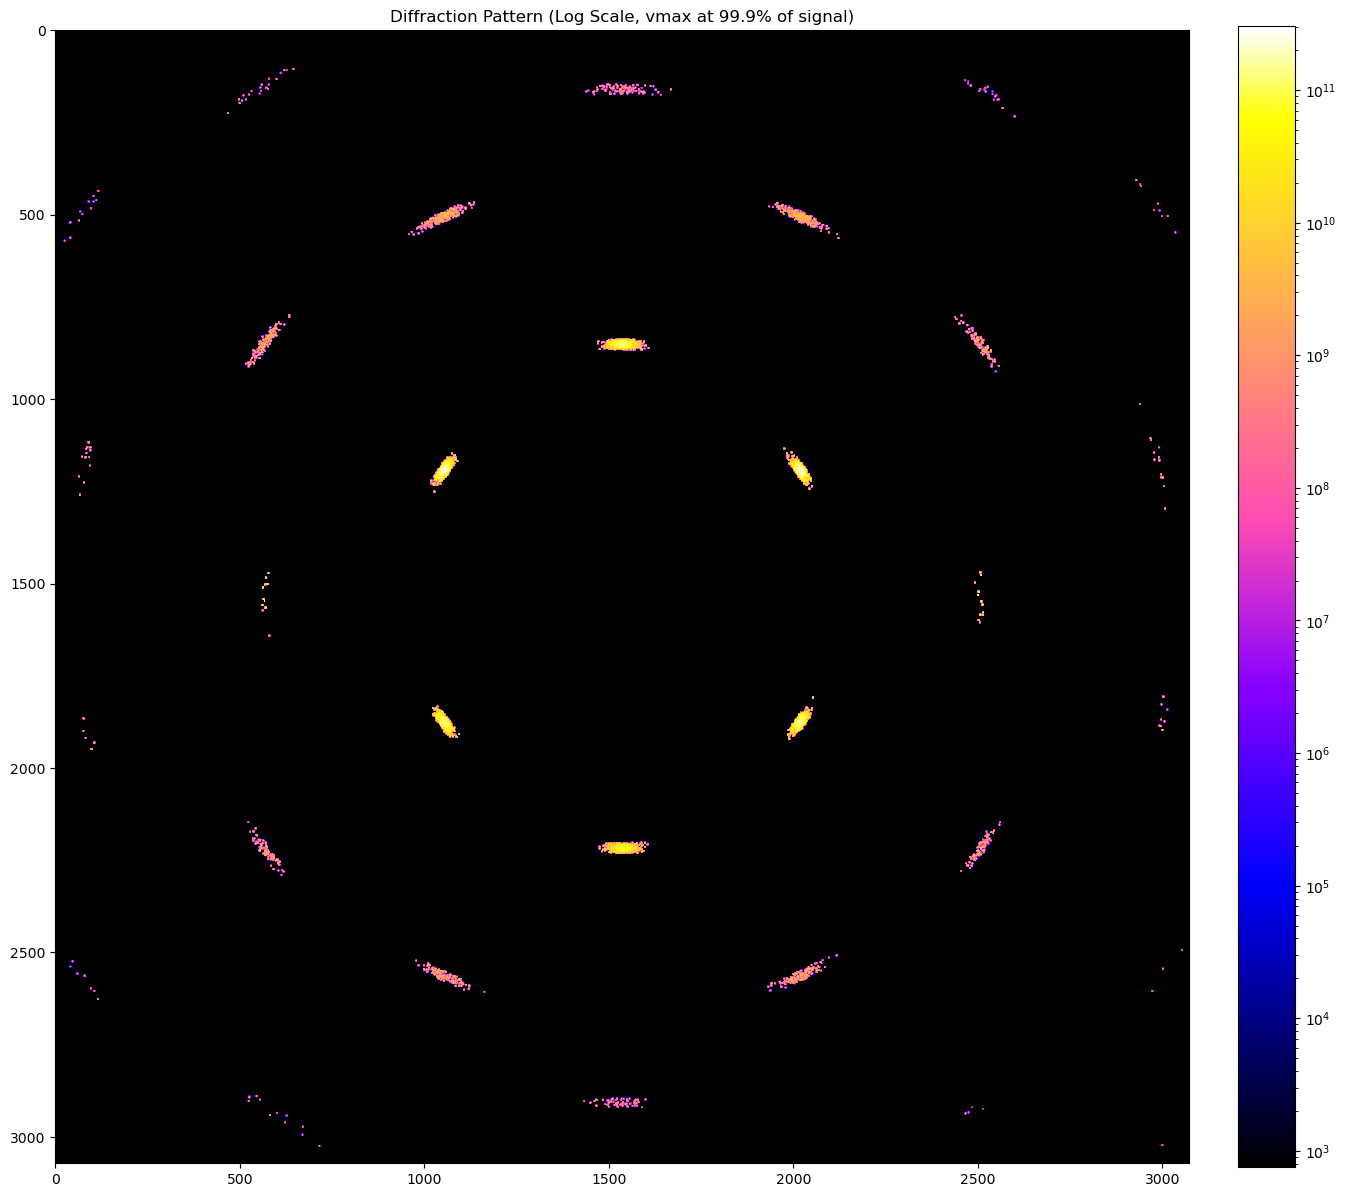

In [22]:
# --- 6. 显示结果 (对数标尺 + 对比度调整) ---
fig, ax = plt.subplots(1, 1, figsize=(16, 15))

# 筛选出所有非零的强度值（即有衍射信号的像素）
positive_intensities = diffraction_pattern[diffraction_pattern > 0]

# 检查是否存在信号
if positive_intensities.size > 0:
    # 对于对数标尺，vmin 必须是一个很小的正数
    # 我们可以用数据中存在的最小正值
    vmin_val = positive_intensities.min()
    
    # vmax 仍然可以用百分位数来确定，以排除最亮的伪影或过曝点
    # 使用对数标尺时，可以显示更多亮点，因此可以尝试更高的百分位，如99.9%
    vmax_percentile = 99.9 
    vmax_val = np.percentile(positive_intensities, vmax_percentile)
else:
    # 如果图中没有任何信号，则使用默认值
    vmin_val = 0.1 # LogNorm 需要一个大于0的 vmin
    vmax_val = 1
    print("警告：衍射图中未找到任何有效信号。")

print(f"原始数据最大值: {diffraction_pattern.max():.2e}") # 使用科学计数法显示
print(f"使用对数标尺显示，范围: vmin={vmin_val:.2e}, vmax={vmax_val:.2e}")

# 渲染图像，在 norm 参数中传入 LogNorm 对象
im = ax.imshow(
    diffraction_pattern,
    cmap='gnuplot2', # 'plasma' 或 'viridis' 在对数标尺下效果很好
    interpolation='nearest',
    norm=LogNorm(vmin=vmin_val, vmax=vmax_val, clip=True) # 使用LogNorm并裁剪范围
)

# 添加颜色条，它会自动显示对数刻度
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_title(f"Diffraction Pattern (Log Scale, vmax at {vmax_percentile}% of signal)")
plt.show()

原始数据最大值: inf
为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: 185881456009.94 (有效信号的99.0%百分位)


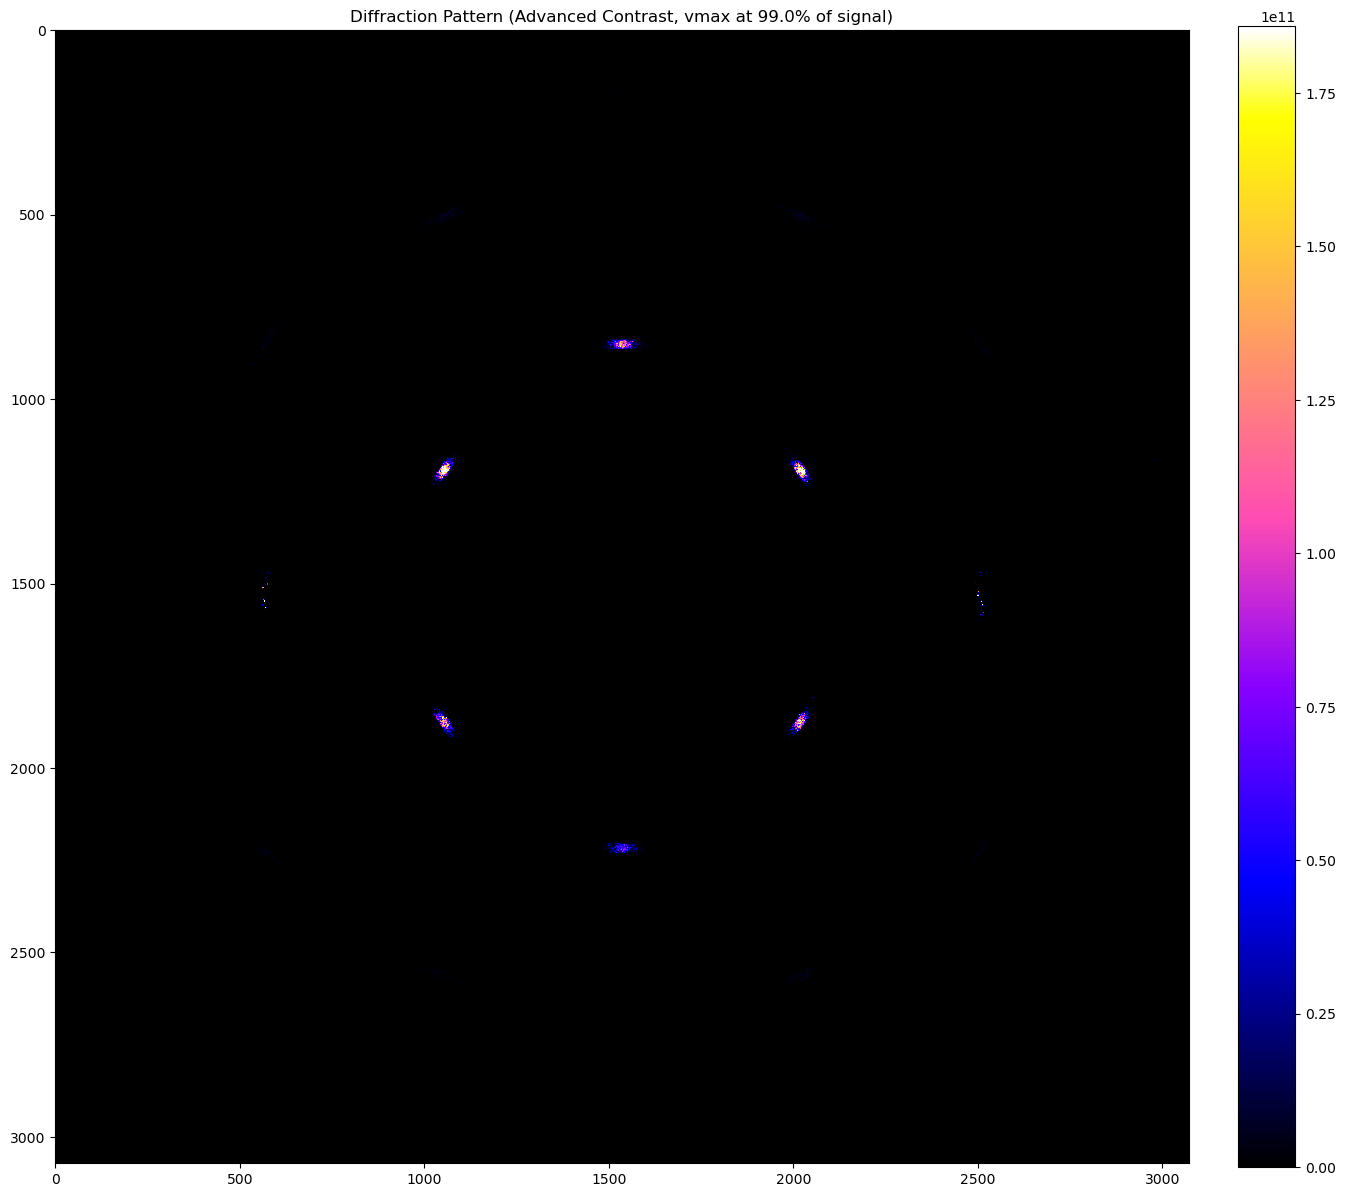

In [23]:
# --- 6. 显示结果 (高级对比度调整) ---
fig, ax = plt.subplots(1, 1, figsize=(16, 15))

positive_intensities = diffraction_pattern[diffraction_pattern > 0]

if positive_intensities.size > 0:
    vmin_val = 0
    vmax_percentile = 99.0 # 使用浮点数以获得更精确的百分位
    vmax_val = np.percentile(positive_intensities, vmax_percentile)
else:
    vmin_val = 0
    vmax_val = 1
    print("警告：衍射图中未找到任何有效信号。")

print(f"原始数据最大值: {diffraction_pattern.max():.2f}")
print(f"为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: {vmax_val:.2f} (有效信号的{vmax_percentile}%百分位)")

im = ax.imshow(
    diffraction_pattern,
    cmap='gnuplot2',
    interpolation='nearest',
    vmin=vmin_val,
    vmax=vmax_val
)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(f"Diffraction Pattern (Advanced Contrast, vmax at {vmax_percentile}% of signal)")
plt.show()

原始数据最大值: inf
为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: 5202667778.87 (有效信号的75.0%百分位)


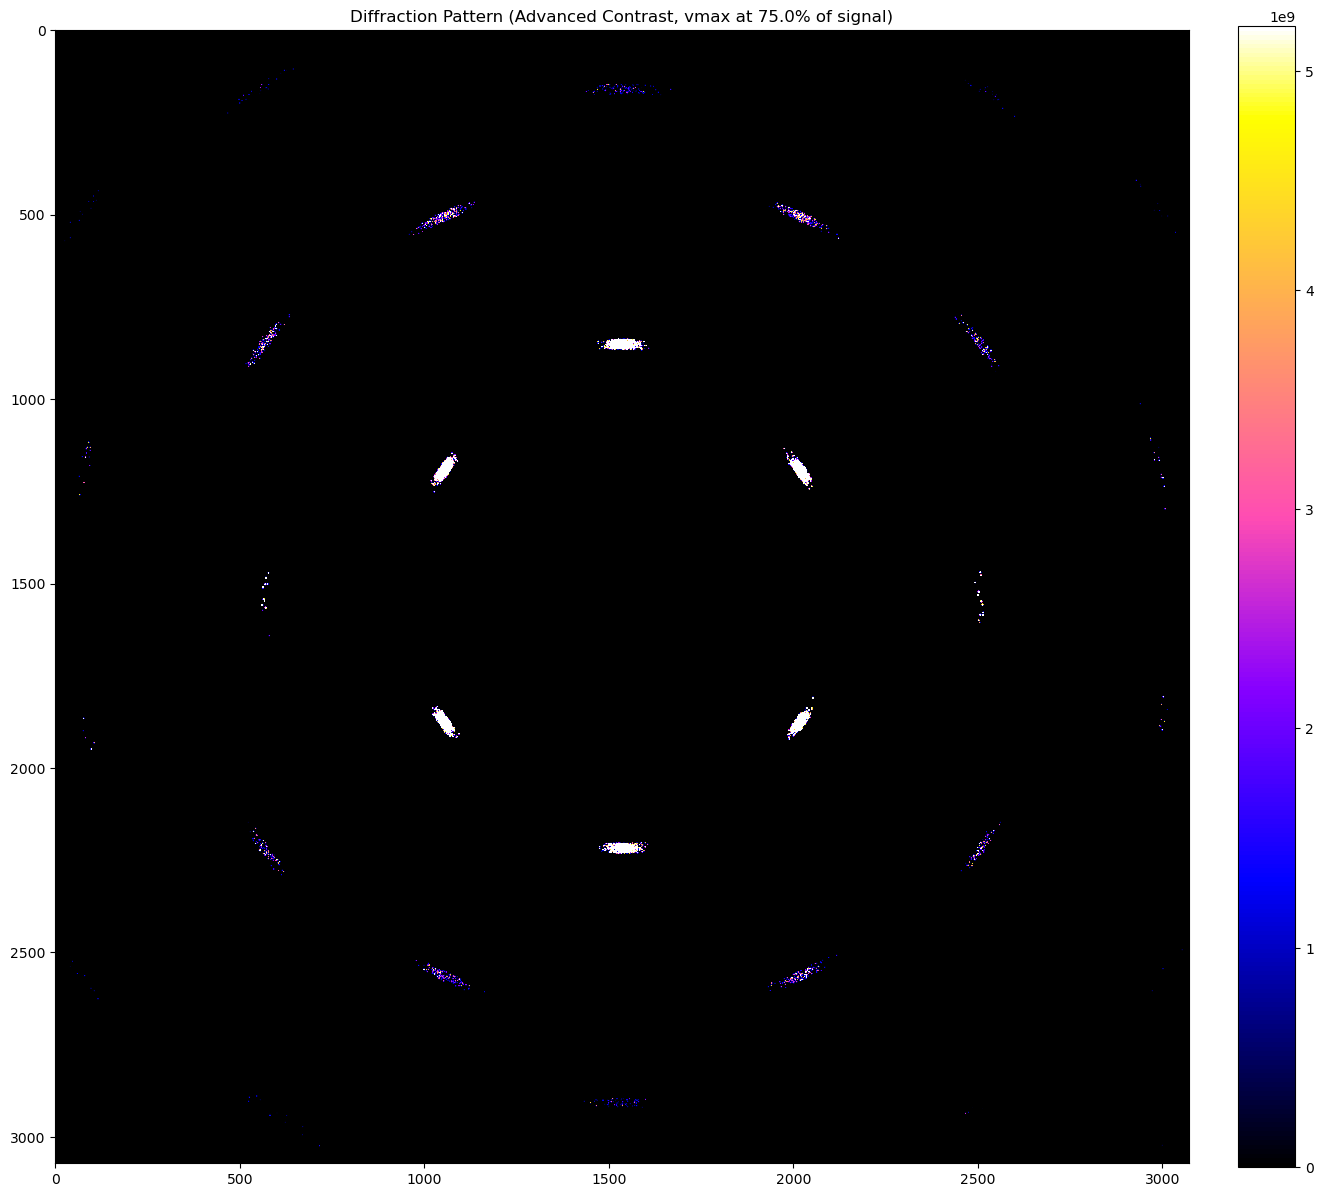

In [24]:
# --- 6. 显示结果 (高级对比度调整) ---
fig, ax = plt.subplots(1, 1, figsize=(16, 15))

positive_intensities = diffraction_pattern[diffraction_pattern > 0]

if positive_intensities.size > 0:
    vmin_val = 0
    vmax_percentile = 75.0 # 使用浮点数以获得更精确的百分位
    vmax_val = np.percentile(positive_intensities, vmax_percentile)
else:
    vmin_val = 0
    vmax_val = 1
    print("警告：衍射图中未找到任何有效信号。")

print(f"原始数据最大值: {diffraction_pattern.max():.2f}")
print(f"为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: {vmax_val:.2f} (有效信号的{vmax_percentile}%百分位)")

im = ax.imshow(
    diffraction_pattern,
    cmap='gnuplot2',
    interpolation='nearest',
    vmin=vmin_val,
    vmax=vmax_val
)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(f"Diffraction Pattern (Advanced Contrast, vmax at {vmax_percentile}% of signal)")
plt.show()

原始数据最大值: inf
为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: 689668717.39 (有效信号的50.0%百分位)


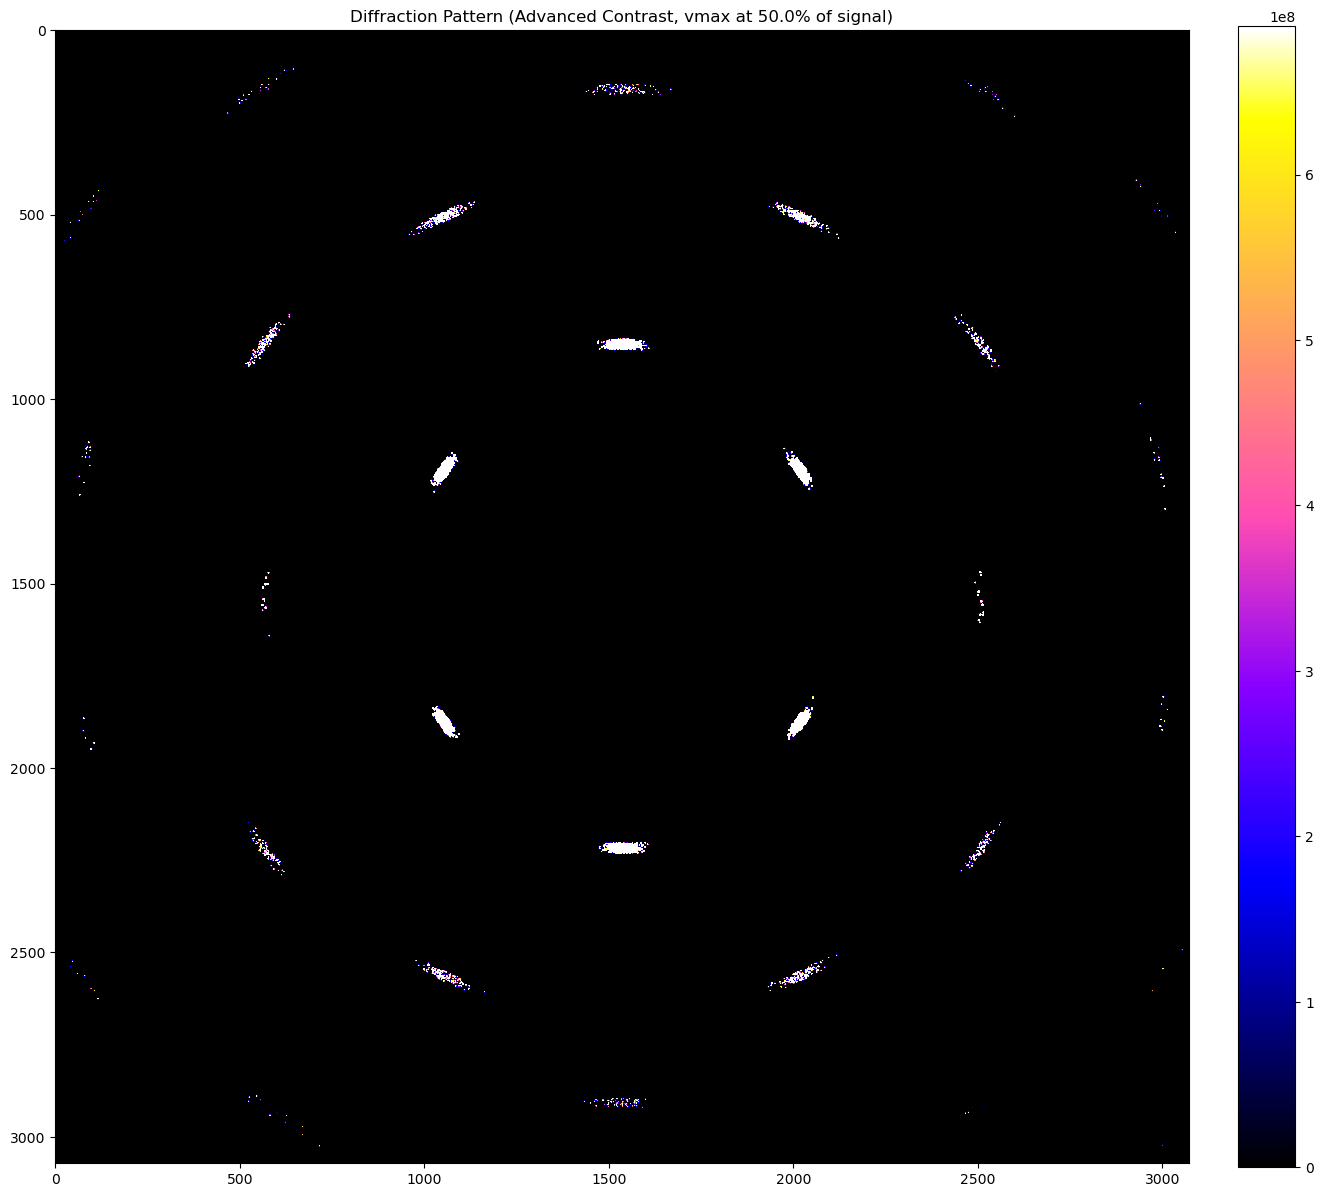

In [25]:
# --- 6. 显示结果 (高级对比度调整) ---
fig, ax = plt.subplots(1, 1, figsize=(16, 15))

positive_intensities = diffraction_pattern[diffraction_pattern > 0]

if positive_intensities.size > 0:
    vmin_val = 0
    vmax_percentile = 50.0 # 使用浮点数以获得更精确的百分位
    vmax_val = np.percentile(positive_intensities, vmax_percentile)
else:
    vmin_val = 0
    vmax_val = 1
    print("警告：衍射图中未找到任何有效信号。")

print(f"原始数据最大值: {diffraction_pattern.max():.2f}")
print(f"为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: {vmax_val:.2f} (有效信号的{vmax_percentile}%百分位)")

im = ax.imshow(
    diffraction_pattern,
    cmap='gnuplot2',
    interpolation='nearest',
    vmin=vmin_val,
    vmax=vmax_val
)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(f"Diffraction Pattern (Advanced Contrast, vmax at {vmax_percentile}% of signal)")
plt.show()

原始数据最大值: inf
为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: 55422181.66 (有效信号的25.0%百分位)


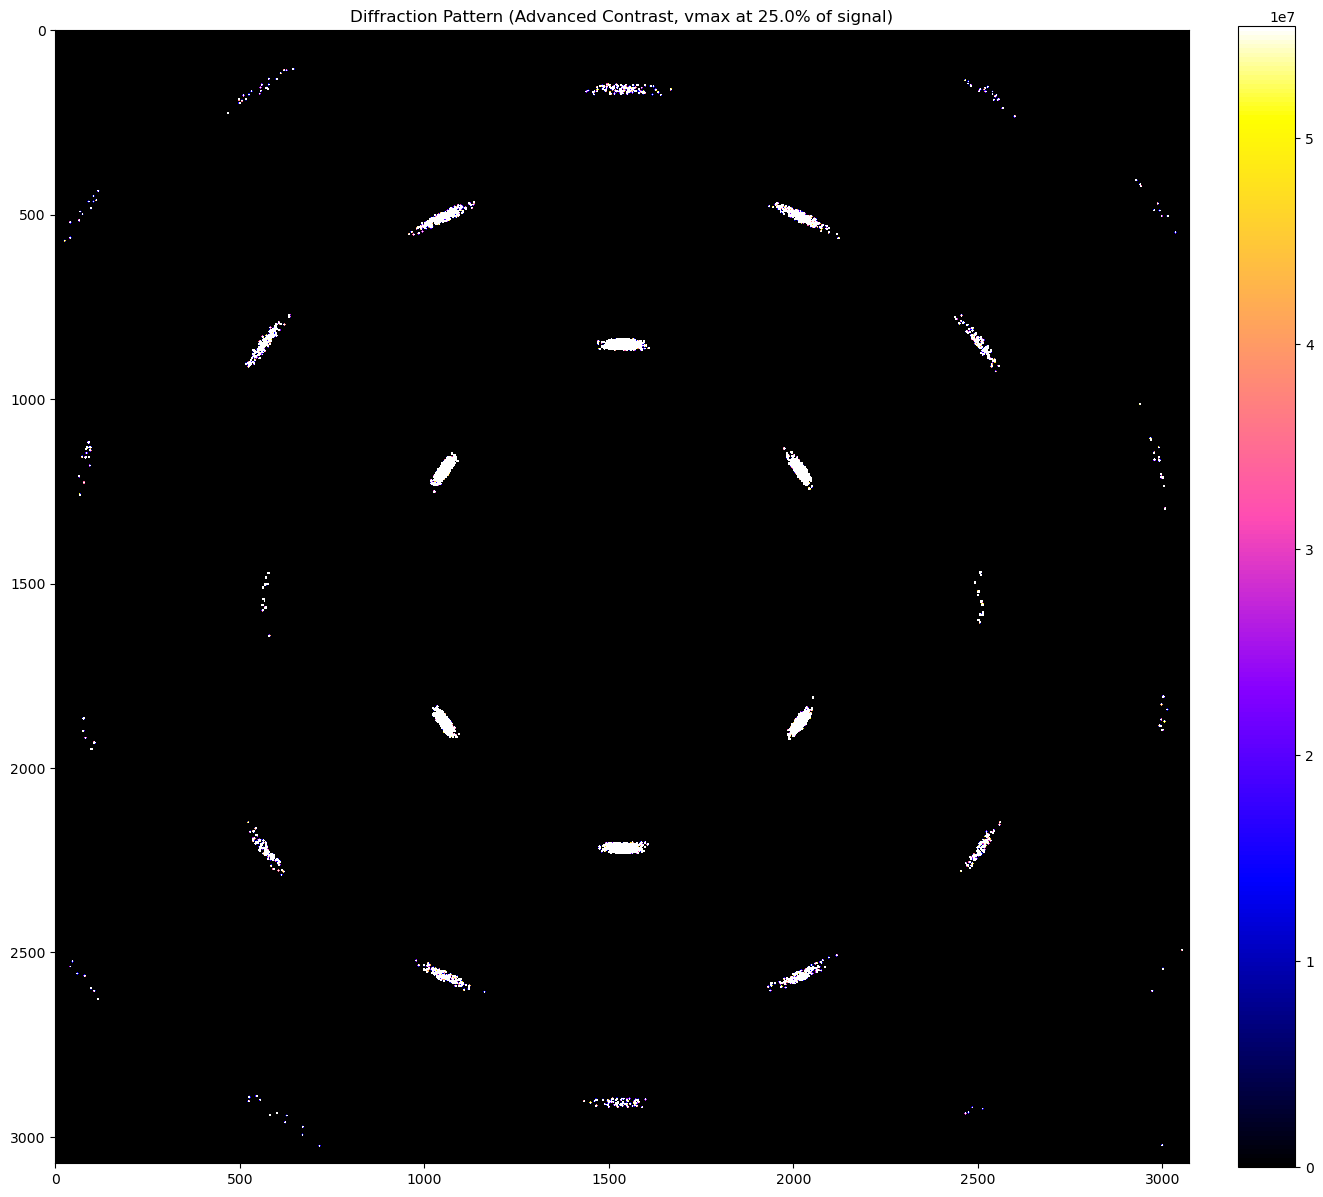

In [26]:
# --- 6. 显示结果 (高级对比度调整) ---
fig, ax = plt.subplots(1, 1, figsize=(16, 15))

positive_intensities = diffraction_pattern[diffraction_pattern > 0]

if positive_intensities.size > 0:
    vmin_val = 0
    vmax_percentile = 25.0 # 使用浮点数以获得更精确的百分位
    vmax_val = np.percentile(positive_intensities, vmax_percentile)
else:
    vmin_val = 0
    vmax_val = 1
    print("警告：衍射图中未找到任何有效信号。")

print(f"原始数据最大值: {diffraction_pattern.max():.2f}")
print(f"为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: {vmax_val:.2f} (有效信号的{vmax_percentile}%百分位)")

im = ax.imshow(
    diffraction_pattern,
    cmap='gnuplot2',
    interpolation='nearest',
    vmin=vmin_val,
    vmax=vmax_val
)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(f"Diffraction Pattern (Advanced Contrast, vmax at {vmax_percentile}% of signal)")
plt.show()

In [27]:
# 保存晶体模型，便于后续使用或可视化
polycrystal.save('Nickel_crystal', save_mesh_as_xdmf=True)  # 保存为xdmf格式，可在ParaView等软件中查看